## LLaMA 2 指令微调（Alpaca-Style on Dolly-15K Dataset)

示例代码关键训练要素：
- 使用 Dolly-15K 数据集，以 Alpaca 指令风格生成训练数据
- 以 4-bit（NF4）量化精度加载 `LLaMA 2-7B` 模型
- 使用 QLoRA 以 `bf16` 混合精度训练模型
- 使用 `HuggingFace TRL` 的 `SFTTrainer` 实现监督指令微调
- 使用 Flash Attention 快速注意力机制加速训练（需硬件支持）

### 下载 databricks-dolly-15k 数据集

In [1]:
from datasets import load_dataset
from random import randrange
 
# 从hub加载数据集
original_dataset = load_dataset("databricks/databricks-dolly-15k", split="train") # 这里使用了dolly-15k数据集

/home/wangfuxin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 数据集样例总数: 15011, 由于显卡不支持Flash Attention加速，全数据集训练耗时太长，选择3000个样本进行训练
print(f"原始数据集样例总数: {len(original_dataset)}")
dataset = original_dataset.shuffle(seed=43).select(range(3000)) # 选择3000个样本进行训练
print(f"筛选后数据集样例总数: {len(dataset)}")

原始数据集样例总数: 15011
筛选后数据集样例总数: 3000


In [3]:
# 随机抽选一个数据样例打印
print(dataset[randrange(len(dataset))])

{'instruction': "Was She Couldn't Say No movie re-released?", 'context': "She Couldn't Say No is a 1954 American rural comedy film starring Robert Mitchum, Jean Simmons and Arthur Hunnicutt. The last film in the long directing career of Lloyd Bacon, it was later re-released as Beautiful but Dangerous", 'response': "Yes, She Couldn't Say No is a 1954 rural comedy film which was later re-released as Beautiful but Dangerous.", 'category': 'information_extraction'}


### 以 Alpaca-Style 格式化指令数据

`Alpacca-style` 格式：https://github.com/tatsu-lab/stanford_alpaca#data-release

In [4]:
def format_instruction(sample_data): # 格式化指令
    """
    Formats the given data into a structured instruction format. 

    Parameters:
    sample_data (dict): A dictionary containing 'response' and 'instruction' keys.

    Returns:
    str: A formatted string containing the instruction, input, and response.
    """
    # 检查样本数据中是否存在要求的关键字
    
    if 'response' not in sample_data or 'instruction' not in sample_data:
        
        # 如果缺少关键字，返回错误信息
        return "Error: 'response' or 'instruction' key missing in the input data."

    return f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM. 
 
### Input:
{sample_data['response']}
 
### Response:
{sample_data['instruction']}
"""

In [5]:
# 随机抽选一个样例，打印 Alpaca 格式化后的样例 
print(format_instruction(dataset[randrange(len(dataset))]))

### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM. 
 
### Input:
House of the Dragon is an American fantasy drama television series created by George R. R. Martin and Ryan Condal for HBO. A prequel to Game of Thrones (2011–2019), it is the second television series in the A Song of Ice and Fire franchise. Condal and Miguel Sapochnik served as the showrunners for the first season. Based on Martin's 2018 novel Fire & Blood, the series is set about 100 years after the Seven Kingdoms are united by the Targaryen Conquest, nearly 200 years before the events of Game of Thrones, and 172 years before the birth of Daenerys Targaryen. Featuring an ensemble cast, the show portrays the events leading up to the beginning of the decline of House Targaryen, a devastating war of succession known as the "Dance of the Dragons".

House of the Dragon received a straight-to-series order in October 2019, with casting beginning in July 

### 使用快速注意力（Flash Attention）加速训练

检查你的 GPU 是否支持 `flash-attn` 加速：

```shell
$ python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
AssertionError: Hardware not supported for Flash Attention
```
**运行结果：演示使用的 NVIDIA T4 硬件不支持 Flash Attention**

#### 安装 flash-attn 加速包（需要GPU硬件支持）

```shell
$ MAX_JOBS=4 pip install flash-attn --no-build-isolation
```

### 经过尝试，云端主机使用的GPU Tesla T4，硬件不支持 Flash Attention，但加速包安装却显示成功的，却不起作用。没能达成优化加速效果，训练时长100步需要13小时
\:\(

### 加载模型

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 先初始化use_flash_attention为False，如果硬件设备支持，成功安装 flash-attn后，后面的代码会将其改为True
use_flash_attention = False
 
# 检查GPU是否支持 Flash Attention，如果支持则替换模型中的注意力机制为 Flash Attention
if torch.cuda.get_device_capability()[0] >= 8:
    from utils.llama_patch import replace_attn_with_flash_attn
    print("Using flash attention")
    replace_attn_with_flash_attn()
    use_flash_attention = True

print(torch.cuda.get_device_capability()) # 打印GPU的计算能力
print("Flash Attention enabled:", use_flash_attention) # 打印use_flash_attention的值，确认是否启用了Flash Attention


(7, 5)
Flash Attention enabled: False


In [7]:
 
# 获取 LLaMA 2-7B 模型权重
# 无需 Meta AI 审核的模型权重,来自huggingface社区，可直接下载使用
model_id = "NousResearch/Llama-2-7b-hf" 
# 通过 Meta AI 审核后可使用此 Model ID 下载
# model_id = "meta-llama/Llama-2-7b-hf" 
 
 
# 使用 BnB 加载量化后的模型
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 4-bit 量化
    bnb_4bit_use_double_quant=True, # 双量化
    bnb_4bit_quant_type="nf4", # 使用 nf4 量化格式
    bnb_4bit_compute_dtype=torch.bfloat16 # 计算数据类型为 bfloat16
)
 
# 加载模型与分词器
model = AutoModelForCausalLM.from_pretrained( # 加载量化模型
    model_id, # 模型 ID
    quantization_config=bnb_config, # 量化配置
    use_cache=False, # 关闭缓存
    device_map="auto" # 自动映射设备
)


/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]
/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
model.config.pretraining_tp = 1 # 设置预训练张量并行度为 1
 
# 通过对比doc中的字符串，验证模型是否在使用flash attention
if use_flash_attention: # 如果使用了 flash attention
    from utils.llama_patch import forward    # 导入 forward 函数
     # 断言模型的 self_attn.forward 方法的文档字符串与 forward 函数的文档字符串相同
    assert model.model.layers[0].self_attn.forward.__doc__ == forward.__doc__, "Model is not using flash attention"
 
# 加载分词器 
tokenizer = AutoTokenizer.from_pretrained(model_id) # 加载分词器
# tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False) # 如果报错
tokenizer.pad_token = tokenizer.eos_token # 设置填充标记为结束标记
tokenizer.padding_side = "right" # 设置填充方向为右侧

### 使用 QLoRA 配置加载 PEFT 模型

In [9]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
 
# QLoRA 配置
peft_config = LoraConfig(
        lora_alpha=16, # Lora alpha 参数，控制 Lora 层的输出缩放
        lora_dropout=0.1, # dropout 比例，防止过拟合
        r=8, # Lora 矩阵秩
        bias="none", # 偏置项，不使用偏置
        task_type="CAUSAL_LM", # 任务类型为因果语言模型 
)
 
# 使用 QLoRA 配置加载 PEFT 模型
model = prepare_model_for_kbit_training(model) # 准备模型进行 k-bit 训练
qlora_model = get_peft_model(model, peft_config) # 获取 PEFT 模型

In [10]:
qlora_model.print_trainable_parameters() # 打印可训练参数

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


### 训练超参数

In [12]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") # 获取当前时间戳

# 演示训练参数（实际训练是设置为 False）
demo_train = False # 正式训练
output_dir = f"models/llama-7-int4-dolly-{timestamp}"

In [13]:
output_dir # 输出目录

'models/llama-7-int4-dolly-20250830_010107'

In [14]:
from transformers import TrainingArguments
 
args = TrainingArguments(
    output_dir=output_dir, # 输出目录
    num_train_epochs=1 if demo_train else 3, # 训练轮数
    # max_steps=100, # 最大训练步数, 如果不设置，则按训练轮数训练将达到288步，耗时过长
    per_device_train_batch_size=3, # Nvidia T4 16GB 显存支持的最大 Batch Size
    gradient_accumulation_steps=1 if demo_train else 4, # 梯度累积步数
    gradient_checkpointing=True, # 启用梯度检查点
    optim="paged_adamw_32bit", # 优化器, paged_adamw_32bit适合大模型
    logging_steps=20, # 日志记录步数, 改为20步做checkpoint
    save_strategy="steps" if demo_train else "epoch", # 保存策略
    save_steps=10, # 保存步数
    learning_rate=2e-4, # 学习率
    bf16=True, # 使用 bfloat16 进行训练,需要 GPU 支持
    max_grad_norm=0.3, # 最大梯度范数
    warmup_ratio=0.03, # 预热比例
    lr_scheduler_type="constant" # 学习率调度器类型
)

### 实例化 SFTTrainer

In [15]:
from trl import SFTTrainer
 
# 数据集的最大长度序列（筛选后的训练数据样例数为1158）
max_seq_length = 2048 
# 使用 SFTTrainer 进行训练，使用训练集无需提前进行分词运算，由于SFTTrainer会在每个训练批次中动态处理输入数据，由SFTTrainer负责将文本转换为模型输入格式
 
trainer = SFTTrainer( #使用 SFTTrainer 进行训练,适用于监督微调
    model=qlora_model, # PEFT 模型 
    train_dataset=dataset, # 训练数据集,改为3000条，缩小训练集规模
    peft_config=peft_config, # PEFT 配置
    max_seq_length=max_seq_length, # 最大序列长度
    tokenizer=tokenizer, # 分词器
    packing=True, # 启用打包
    formatting_func=format_instruction, # 格式化函数
    args=args, # 训练参数
)

Generating train split: 241 examples [00:00, 367.89 examples/s]


### 训练模型

In [16]:
trainer.train()

/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
20,1.470600
40,1.254100
60,1.214500


/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=60, training_loss=1.313038126627604, metrics={'train_runtime': 28554.4358, 'train_samples_per_second': 0.025, 'train_steps_per_second': 0.002, 'total_flos': 5.816968582004736e+16, 'train_loss': 1.313038126627604, 'epoch': 2.96})

#### 训练时GPU资源使用情况

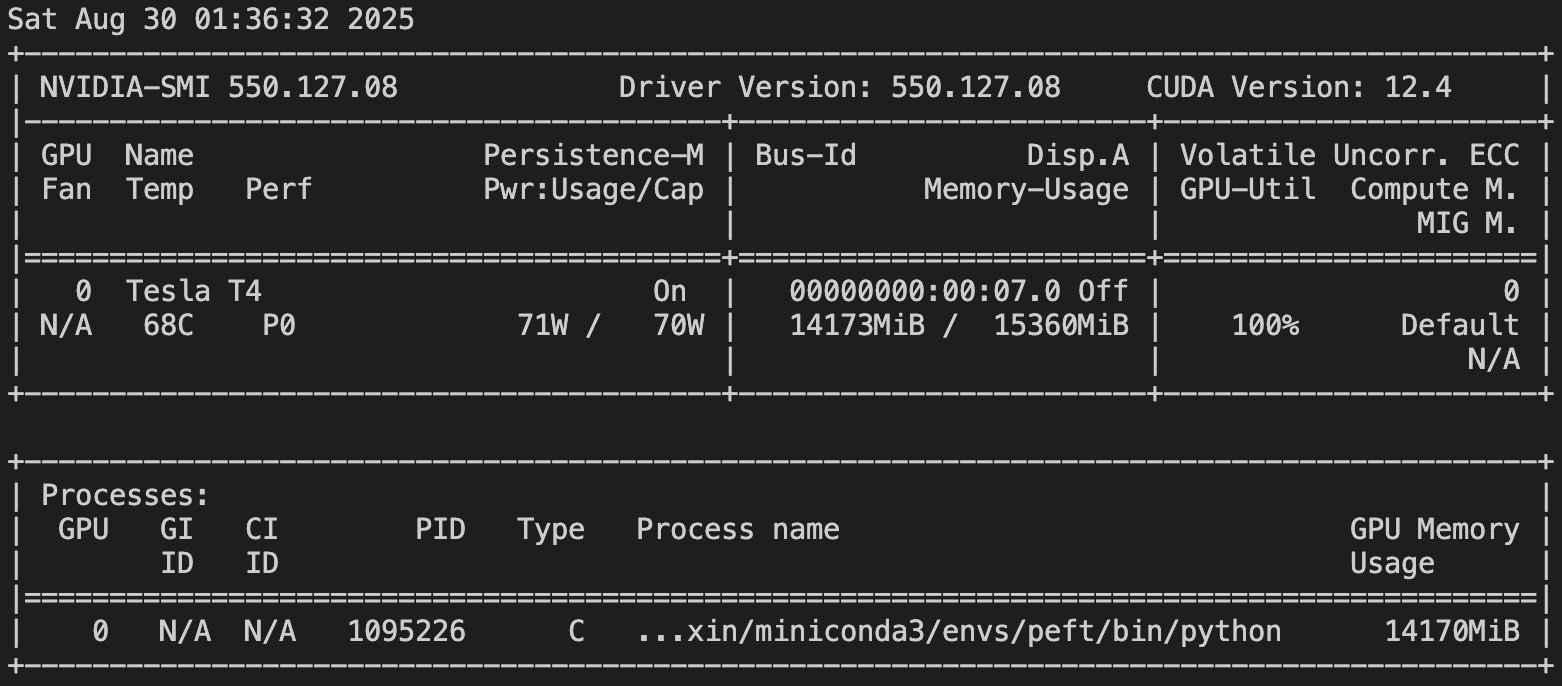

### 保存模型

In [17]:
trainer.save_model()

### 模型推理（测试）